In [2]:
import wandb
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
api = wandb.Api()

In [3]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [4]:
entity, project = "real-lab", "simple-icl"
runs = api.runs(entity + "/" + project)
SAVE_DIR = "plotting/plots/camera_ready"

In [5]:
ENVS = ["walker2d", "inverted_pendulum", "swimmer", "half_cheetah", "ant"]
NAMES_DICT = {"sc_l2_pr_warmstart_lag0": "IRL-L2+SC+PR",
              "sc_l2_warmstart_lag0": "IRL-L2+SC",
              "l2_pr_new": "IRL-L2+PR",
              "l2_new": "IRL-L2",
              "orig_irl_rn_lag0": "IRL-Base",
              "orig_irl_rn_bn_lag0": "IRL-Base+BN",
              "MECL": "MECL",
              "GACL": "GACL"}

In [6]:
def get_aggregate_scores(score_dict, mets=["iqm"], reps=50000):
  metrics_dict = {"iqm": metrics.aggregate_iqm,
                  "median": metrics.aggregate_median,
                  "mean": metrics.aggregate_mean,
                  "optimality_gap": metrics.aggregate_optimality_gap}
  # Load ALE scores as a dictionary mapping algorithms to their human normalized
  # score matrices, each of which is of size `(num_runs x num_games)`.
  score_dict = {key: np.expand_dims(np.array(val),-1) if len(np.array(val).shape)==1 else val for key, val in score_dict.items()}
  aggregate_func = lambda x: np.array([metrics_dict[metric](x) for metric in mets])
  aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
    score_dict, aggregate_func, reps=reps)
  return aggregate_scores, aggregate_score_cis

In [7]:
def get_data(runs, env_name_fn, metrics=["test/feasible_reward", "test/violation_rate"], x_axis="_step", 
             add_from_config=["seed"], index=np.arange(0.,5005000.,5000)):
    df = pd.DataFrame()
    run_id = 0
    for run in runs:
        temp_df = run.history(keys=metrics, x_axis=x_axis, samples=1000)
        if len(temp_df) == 0:
            continue
        if index is not None:
            temp_df = temp_df.set_index(x_axis).reindex(index, method="nearest", tolerance=5000).reset_index()
        temp_df['config'] = ''.join(run.tags)
        temp_df['run_id'] = run_id
        temp_df["env"] = env_name_fn(run.config)
        for x in add_from_config:
            cons = x.split(".")
            temp = run.config[cons[0]]
            for con in cons[1:]:
                temp = temp[con]
            temp_df[x] = temp
        df = pd.concat([df, temp_df])
        run_id += 1
    df = df.reset_index(drop=True)
    df.columns = df.columns.str.split('/').str[-1]
    return df

In [8]:
def plot_iqm(plot_df, metric="normalized_rewards", max_time=4500000, exclude_cis=False, bootstrap_samples=50000, num_seeds=5):
  sns.set(font_scale=0.8)
  print(max_time)
  algorithms = list(plot_df.config.unique())
  # Load ALE scores as a dictionary mapping algorithms to their human normalized
  # score matrices across all 200 million frames, each of which is of size
  # `(num_runs x num_games x 200)` where scores are recorded every million frame.
  num_envs = len(plot_df.env.unique())
  cnt = plot_df.groupby(["config","env","run_id"])._step.count().iloc[0]
  print(cnt)
  plot_df = plot_df.set_index("_step").loc[np.arange(0,max_time, 5000)[1:],:].reset_index(drop=False).drop_duplicates(["_step", "config", "run_id", "env"])
  ale_all_frames_scores_dict = {NAMES_DICT[algorithm]: np.array(plot_df[plot_df.config == algorithm].sort_values(["env", "run_id", "_step"]).set_index(["_step", "env", "run_id"]).rolling(10)[[metric]].mean().reset_index(drop=False).pivot(index="_step", columns=["env", "run_id"], values=metric)).reshape(-1,num_envs,num_seeds).transpose(2,1,0) for algorithm in algorithms}

  frames = np.arange(0, int(max_time/5000)+50, 50)-2


  frames = frames[1:]
  ale_frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                            in ale_all_frames_scores_dict.items()}
  iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                                for frame in range(scores.shape[-1])])
  iqm_scores, iqm_cis = rly.get_interval_estimates(
    ale_frames_scores_dict, iqm, reps=bootstrap_samples)
  if exclude_cis:
    for i, _ in enumerate(iqm_cis):
      iqm_cis[i][0] = iqm_scores[i]
      iqm_cis[i][1] = iqm_scores[i]
  ax = plot_utils.plot_sample_efficiency_curve(
      (frames+1)*5000, iqm_scores, iqm_cis, algorithms=[val for key,val in NAMES_DICT.items() if key in algorithms],
      xlabel=r'Env Steps',
      ylabel=(' ').join(metric.split("_")).upper(), legend=True)
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=4)
  return ax

## Primary Experiments

In [9]:
experiment_names = [key for key in NAMES_DICT.keys()]

In [10]:
experiments = [api.runs(entity + "/" + project, filters={'tags': exp}) for exp in experiment_names]
runs = [run for runs in experiments for run in runs ]
env_name_fn = lambda x: '_'.join(re.sub(r"([A-Z])", r"_\1", x['task'].split('-')[0]).split('_')[1:-1]).lower()

In [11]:
experiments = [api.runs(entity + "/icrl", filters={'tags': "MECL", "state": "finished"})]
mecl_runs = [run for x in experiments for run in x ]
experiments = [api.runs(entity + "/icrl", filters={'tags': "GACL", "state": "finished"})]
gacl_runs = [run for x in experiments for run in x ]

In [12]:
envname_dict = {"AntWall": "ant", "HCWithPos": "half_cheetah", "InvertedPendulumWall": "inverted_pendulum", 
                "WalkerWithPos": "walker2d", "SwmWithPos": "swimmer"}
baseline_env_name_fn = lambda x: envname_dict[re.match(r".*_(\w+).*", x['config_file']).group(1)]

In [13]:
from datetime import datetime
temp = [f"{run.name.split('_')[0]}/train_{run.name.split('_')[0]}-v0-multi_env-{datetime.strptime(run.name.split('_')[-1], '%Y-%m-%d-%H-%M-%S').strftime('%b-%d-%Y-%H:%M')}-seed_" for run in mecl_runs]
pd.Series(temp).drop_duplicates().tolist()

['ICRL-InvertedPendulumWall/train_ICRL-InvertedPendulumWall-v0-multi_env-Oct-01-2024-14:43-seed_',
 'ICRL-HC/train_ICRL-HC-v0-multi_env-Oct-01-2024-16:46-seed_',
 'ICRL-WalkerWithPos/train_ICRL-WalkerWithPos-v0-multi_env-Oct-01-2024-16:52-seed_',
 'ICRL-AntWall/train_ICRL-AntWall-v0-multi_env-Oct-01-2024-19:39-seed_',
 'ICRL-Swm/train_ICRL-Swm-v0-multi_env-Oct-01-2024-19:41-seed_']

### Print Config

In [14]:
def unnest(d, keys=[]):
    result = []
    for k, v in d.items():
        if isinstance(v, dict):
            result.extend(unnest(v, keys + [k]))
        else:
            result.append(keys + [k,v])
    return result

In [15]:
config_dict = unnest(runs[0].config)
config_dict = {tuple(x[:-1]): x[-1] for x in config_dict}

In [16]:
config_dict

{('data', '_target_'): 'src.data.readers.ICRLReader',
 ('seed',): 0,
 ('task',): 'SwimmerWall-v0',
 ('device',): 'cuda',
 ('logger', 'name'): 'SwimmerWall-v0-0',
 ('logger', 'project'): 'simple-icl',
 ('logger', '_target_'): 'fsrl.utils.logger.WandbLogger',
 ('policy', 'tau'): 0.005,
 ('policy', 'actor', '_target_'): 'src.utils.net.continuous.ActorProb',
 ('policy', 'actor', 'unbounded'): True,
 ('policy',
  'actor',
  'preprocess_net',
  '_target_'): 'tianshou.utils.net.common.Net',
 ('policy', 'actor', 'preprocess_net', 'hidden_sizes'): [256, 256],
 ('policy', 'actor', 'conditioned_sigma'): True,
 ('policy', 'alpha', 'optim', 'lr'): 0.0003,
 ('policy', 'alpha', 'optim', '_target_'): 'torch.optim.Adam',
 ('policy', 'gamma'): 0.99,
 ('policy', 'n_step'): 1,
 ('policy',
  'critics'): [{'_target_': 'src.utils.net.continuous.DoubleCritic',
   'preprocess_net1': {'concat': True,
    '_target_': 'tianshou.utils.net.common.Net',
    'hidden_sizes': [256, 256]},
   'preprocess_net2': {'concat

In [17]:
config_df = pd.DataFrame.from_dict(config_dict, orient="index")

In [18]:
print(config_df[config_df.index.str[0]=="policy"].to_latex())

\begin{tabular}{ll}
\toprule
 & 0 \\
\midrule
('policy', 'tau') & 0.005000 \\
('policy', 'actor', '_target_') & src.utils.net.continuous.ActorProb \\
('policy', 'actor', 'unbounded') & True \\
('policy', 'actor', 'preprocess_net', '_target_') & tianshou.utils.net.common.Net \\
('policy', 'actor', 'preprocess_net', 'hidden_sizes') & [256, 256] \\
('policy', 'actor', 'conditioned_sigma') & True \\
('policy', 'alpha', 'optim', 'lr') & 0.000300 \\
('policy', 'alpha', 'optim', '_target_') & torch.optim.Adam \\
('policy', 'gamma') & 0.990000 \\
('policy', 'n_step') & 1 \\
('policy', 'critics') & [{'_target_': 'src.utils.net.continuous.DoubleCritic', 'preprocess_net1': {'concat': True, '_target_': 'tianshou.utils.net.common.Net', 'hidden_sizes': [256, 256]}, 'preprocess_net2': {'concat': True, '_target_': 'tianshou.utils.net.common.Net', 'hidden_sizes': [256, 256]}}, {'_target_': 'src.utils.net.continuous.DoubleCritic', 'preprocess_net1': {'concat': True, '_target_': 'tianshou.utils.net.commo

In [19]:
print(config_df[config_df.index.str[0]=="reward"].to_latex())

\begin{tabular}{ll}
\toprule
 & 0 \\
\midrule
('reward', 'net', '_target_') & src.utils.net.continuous.Reward \\
('reward', 'net', 'clip_range') & NaN \\
('reward', 'net', 'preprocess_net', 'concat') & True \\
('reward', 'net', 'preprocess_net', '_target_') & tianshou.utils.net.common.Net \\
('reward', 'net', 'preprocess_net', 'norm_layer') & NaN \\
('reward', 'net', 'preprocess_net', 'hidden_sizes') & [64, 64] \\
('reward', 'net', 'initialize_zero') & True \\
('reward', 'net', 'output_transform') & NaN \\
('reward', 'net', 'output_activation', 'path') & torch.nn.LeakyReLU \\
('reward', 'net', 'output_activation', '_target_') & hydra.utils.get_class \\
('reward', 'optim', 'lr') & 0.001000 \\
('reward', 'optim', '_target_') & torch.optim.Adam \\
('reward', 'optim', 'weight_decay') & 0.001000 \\
('reward', '_target_') & src.rewards.reward_learner.RewardLearner \\
('reward', 'batch_size') & 5000 \\
('reward', 'lr_scheduler') & NaN \\
('reward', 'is_constraint') & True \\
('reward', 'loss_

In [20]:
print(config_df[config_df.index.str[0]=="trainer"].to_latex())

\begin{tabular}{ll}
\toprule
 & 0 \\
\midrule
('trainer', '_target_') & src.trainer.OffpolicyTrainer \\
('trainer', 'max_epoch') & 1000 \\
('trainer', 'batch_size') & 128 \\
('trainer', 'step_per_epoch') & 5000 \\
('trainer', 'update_per_step') & 1 \\
('trainer', 'episode_per_test') & 5 \\
('trainer', 'episode_per_collect') & 1 \\
\bottomrule
\end{tabular}



### Get Data

In [21]:
df = get_data(runs, env_name_fn)

In [22]:
(df.dropna().groupby(["env", "config", "run_id"])._step.max()[df.dropna().groupby(["env", "config", "run_id"])._step.max()>=5000000]
 .sort_values(ascending=False).groupby(["env", "config"]).head(5).reset_index(drop=False)).groupby(['env', 'config']).count()

run_id  _step
env               config                                
ant               l2_new                        5      5
                  l2_pr_new                     5      5
                  orig_irl_rn_bn_lag0           5      5
                  orig_irl_rn_lag0              5      5
                  sc_l2_pr_warmstart_lag0       5      5
                  sc_l2_warmstart_lag0          5      5
half_cheetah      l2_new                        5      5
                  l2_pr_new                     5      5
                  orig_irl_rn_bn_lag0           5      5
                  orig_irl_rn_lag0              5      5
                  sc_l2_pr_warmstart_lag0       5      5
                  sc_l2_warmstart_lag0          5      5
inverted_pendulum l2_new                        5      5
                  l2_pr_new                     5      5
                  orig_irl_rn_bn_lag0           5      5
                  orig_irl_rn_lag0              5      5
                  sc_l2_pr_warmstart_lag0       5      5
                  sc_l2_warmstart_lag0          5      5
swimmer           l2_new                        5      5
                  l2_pr_new                     5      5
                  orig_irl_rn_bn_lag0           5      5
                  orig_irl_rn_lag0              5      5
                  sc_l2_pr_warmstart_lag0       5      5
                  sc_l2_warmstart_lag0          5      5
walker2d          l2_new                        5      5
                  l2_pr_new                     5      5
                  orig_irl_rn_bn_lag0           5      5
                  orig_irl_rn_lag0              5      5
                  sc_l2_pr_warmstart_lag0       5      5
                  sc_l2_warmstart_lag0          5      5

In [23]:
mecl_df = get_data(mecl_runs, baseline_env_name_fn, 
                        metrics=["rollout/ep_reward_nc_mean", "rollout/ep_constraint_mean"],
                        x_axis="timesteps", index=None).rename(columns={"ep_reward_nc_mean": "feasible_reward", 
                                                                        "ep_constraint_mean": "violation_rate",
                                                                        "timesteps": "_step"})

In [24]:
gacl_df = get_data(gacl_runs, baseline_env_name_fn, 
                        metrics=["true/mean_nc_reward", "true/violation_rate"],
                        x_axis="timestep", index=None).rename(columns={"mean_nc_reward": "feasible_reward", "timestep": "_step"})

In [25]:
limit = 5000000
num_seeds = 5
indices = (df.dropna().groupby(["env", "config", "run_id"])._step.max()[df.dropna().groupby(["env", "config", "run_id"])._step.max()>=limit]
 .sort_values(ascending=False).groupby(["env", "config"]).head(num_seeds).index)

In [26]:
all_df = df.set_index(["env", "config", "run_id"]).loc[indices,:].reset_index(drop=False)
all_df = all_df.loc[all_df._step <= limit,:]

In [27]:
all_df.groupby(["config", "env", "run_id"])._step.count().groupby(["config", "env"]).count()

config                   env              
l2_new                   ant                  5
                         half_cheetah         5
                         inverted_pendulum    5
                         swimmer              5
                         walker2d             5
l2_pr_new                ant                  5
                         half_cheetah         5
                         inverted_pendulum    5
                         swimmer              5
                         walker2d             5
orig_irl_rn_bn_lag0      ant                  5
                         half_cheetah         5
                         inverted_pendulum    5
                         swimmer              5
                         walker2d             5
orig_irl_rn_lag0         ant                  5
                         half_cheetah         5
                         inverted_pendulum    5
                         swimmer              5
                         walker2d            

In [28]:
counts = (all_df.groupby(["config", "env", "run_id"])._step.count().groupby(["config", "env"]).count() == num_seeds).groupby("config").sum() == 5

In [29]:
counts.index[counts]
all_df = all_df[all_df.config.isin(counts.index[counts])]

In [30]:
all_df.sort_values(["env", "config", "run_id", "_step"]).groupby(["env", "config", "run_id"]).tail(10)

,env,config,run_id,_step,feasible_reward,violation_rate,seed
991,ant,l2_new,115,4955000.0,4675.888305,0.0,0
992,ant,l2_new,115,4960000.0,3781.493696,0.0,0
993,ant,l2_new,115,4965000.0,7955.089663,0.0,0
994,ant,l2_new,115,4970000.0,7461.026213,0.0,0
995,ant,l2_new,115,4975000.0,8454.983354,0.0,0
...,...,...,...,...,...,...,...
150145,walker2d,sc_l2_warmstart_lag0,34,4980000.0,465.793963,0.0,3
150146,walker2d,sc_l2_warmstart_lag0,34,4985000.0,671.393093,0.0,3
150147,walker2d,sc_l2_warmstart_lag0,34,4990000.0,341.901551,0.0,3
150148,walker2d,sc_l2_warmstart_lag0,34,4995000.0,189.691466,0.0,3


In [31]:
import os
expert_rewards = {}
for env in ["inverted_pendulum", "half_cheetah", "walker2d", "swimmer", "ant"]:
    file_names = sorted(os.listdir(f'../data/icrl/{env}'))
    import os
    import pickle
    rewards = []
    for file_name in file_names:
        with open(os.path.join(f'../data/icrl/{env}', file_name), "rb") as f:
            data = pickle.load(f)
            rewards.append(data['reward_sum'])
    expert_rewards[env] = np.array(rewards).mean()


In [32]:
expert_rewards['half_cheetah'] = expert_rewards['half_cheetah']*2

In [33]:
all_df['expert_rewards'] = all_df['env'].map(expert_rewards)
gacl_df["expert_rewards"] = gacl_df["env"].map(expert_rewards)
mecl_df["expert_rewards"] = mecl_df["env"].map(expert_rewards)

In [34]:
mecl_df

,_step,feasible_reward,violation_rate,config,run_id,env,seed,expert_rewards
0,20480.0,1.3097,0.77,MECL,0,inverted_pendulum,0,56.804461
1,40960.0,1.3588,0.97,MECL,0,inverted_pendulum,0,56.804461
2,61440.0,1.3009,1.00,MECL,0,inverted_pendulum,0,56.804461
3,81920.0,1.8208,0.99,MECL,0,inverted_pendulum,0,56.804461
4,102400.0,2.0682,0.99,MECL,0,inverted_pendulum,0,56.804461
...,...,...,...,...,...,...,...,...
3874,4915200.0,92.7245,1.00,MECL,24,swimmer,2,800.886018
3875,4966400.0,86.1508,1.00,MECL,24,swimmer,2,800.886018
3876,5017600.0,82.4684,1.00,MECL,24,swimmer,2,800.886018
3877,5068800.0,95.3182,1.00,MECL,24,swimmer,2,800.886018


In [35]:
all_df['normalized_rewards'] = all_df['feasible_reward'] / all_df['expert_rewards']
mecl_df['normalized_rewards'] = mecl_df['feasible_reward'] / mecl_df['expert_rewards']
gacl_df['normalized_rewards'] = gacl_df['feasible_reward'] / gacl_df['expert_rewards']

In [36]:
all_df.config.unique()

array(['l2_new', 'orig_irl_rn_bn_lag0', 'l2_pr_new',
       'sc_l2_pr_warmstart_lag0', 'orig_irl_rn_lag0',
       'sc_l2_warmstart_lag0'], dtype=object)

In [37]:
results_df = all_df.sort_values(["env", "config", "run_id", "_step"]).groupby(["env", "config", "run_id"]).tail(10).groupby(["env", "config", "run_id"]).mean()
mecl_results_df = mecl_df.sort_values(["env", "config", "seed", "_step"]).groupby(["env", "config", "seed"]).last().groupby(["env", "config", "seed"]).mean()
gacl_results_df = gacl_df.sort_values(["env", "config", "seed", "_step"]).groupby(["env", "config", "seed"]).tail(5).groupby(["env", "config", "seed"]).mean()


In [38]:
results_df = pd.concat([results_df, mecl_results_df, gacl_results_df])

In [39]:
results = {}
results["feasible_reward"] = results_df.groupby(["env", "config"]).feasible_reward.apply(list)
results["violation_rate"] = results_df.groupby(["env", "config"]).violation_rate.apply(list)
results["normalized_rewards"] = results_df.groupby(["env", "config"]).normalized_rewards.apply(list)
results["feasible_reward"] = results["feasible_reward"].groupby(level=0).apply(lambda df: [df.xs(df.name).to_dict()]).to_dict()
results["violation_rate"] = results["violation_rate"].groupby(level=0).apply(lambda df: [df.xs(df.name).to_dict()]).to_dict()
results["normalized_rewards"] = results["normalized_rewards"].groupby(level=0).apply(lambda df: [df.xs(df.name).to_dict()]).to_dict()
results["feasible_reward"] = {k: v[0] for k,v in results["feasible_reward"].items()}
results["violation_rate"] = {k: v[0] for k,v in results["violation_rate"].items()}
results["normalized_rewards"] = {k: v[0] for k,v in results["normalized_rewards"].items()}

In [40]:
for exp in ["MECL", "GACL"]:
    for env in ENVS:
        fr = []
        vr = []
        nr = []
        for seed in range(5):
            temp = pd.DataFrame()
            try:
                for monitor in range(5):
                    name = 'icrl' if exp=='MECL' else 'gail'
                    temp = pd.concat([temp, pd.read_csv(f"../results/{name}/{env}/seed_{seed}/r{monitor}_monitor.csv", header=1).tail(10)])
                fr.append(temp.reward_nc.mean())
                vr.append(temp.constraint.mean())
                nr.append(temp.reward_nc.mean() / expert_rewards[env])
            except:
                continue
        if len(fr) > 0:
            results["feasible_reward"][env][exp] = fr
            results["violation_rate"][env][exp] = vr
            results["normalized_rewards"][env][exp] = nr

In [41]:
results["normalized_rewards"]["swimmer"]["MECL"]

[0.3631675339817264,
 0.556886735712147,
 0.1281500709824831,
 0.030472001589139496,
 0.026507642204207232]

In [42]:
mecl_results_df

_step  feasible_reward  violation_rate  \
env               config seed                                                
ant               MECL   0     10240000.0       11315.2800            0.00   
                         1     10240000.0        1950.4898            0.02   
                         2     10240000.0       10735.3700            0.00   
                         3     10240000.0        4944.9373            0.00   
                         4     10240000.0        6083.9254            0.00   
half_cheetah      MECL   0      6144000.0          49.7404            1.00   
                         1      6144000.0        2642.8079            0.00   
                         2      6144000.0        2691.1522            0.00   
                         3      6144000.0        4123.3692            0.00   
                         4      6144000.0        2369.1802            0.00   
inverted_pendulum MECL   0     10240000.0          11.6397            0.07   
                         1     10240000.0           1.9295            1.00   
                         2     10240000.0           1.3510            1.00   
                         3     10240000.0           2.3193            1.00   
                         4     10240000.0           8.8028            0.67   
swimmer           MECL   0      5120000.0         228.5646            0.77   
                         1      5120000.0         435.5010            0.45   
                         2      5120000.0          93.7736            1.00   
                         3      5120000.0          22.9611            1.00   
                         4      5120000.0          19.9615            1.00   
walker2d          MECL   0     20480000.0          26.8184            0.00   
                         1     20480000.0          44.6857            0.00   
                         2     16179200.0         655.2437            0.84   
                         3     20480000.0         269.4916            0.00   
                         4     20480000.0         593.9137            0.98   

                               run_id  expert_rewards  normalized_rewards  
env               config seed                                              
ant               MECL   0       15.0     8034.335240            1.408365  
                         1       16.0     8034.335240            0.242769  
                         2       17.0     8034.335240            1.336186  
                         3       18.0     8034.335240            0.615476  
                         4       19.0     8034.335240            0.757241  
half_cheetah      MECL   0        5.0     4387.170171            0.011338  
                         1        9.0     4387.170171            0.602395  
                         2        6.0     4387.170171            0.613414  
                         3        7.0     4387.170171            0.939870  
                         4        8.0     4387.170171            0.540025  
inverted_pendulum MECL   0        0.0       56.804461            0.204908  
                         1        1.0       56.804461            0.033967  
                         2        4.0       56.804461            0.023783  
                         3        2.0       56.804461            0.040830  
                         4        3.0       56.804461            0.154967  
swimmer           MECL   0       20.0      800.886018            0.285390  
                         1       21.0      800.886018            0.543774  
                         2       24.0      800.886018            0.117087  
                         3       22.0      800.886018            0.028670  
                         4       23.0      800.886018            0.024924  
walker2d          MECL   0       11.0     1701.883710            0.015758  
                         1       10.0     1701.883710            0.026257  
                         2       13.0     1701.883710            0.385011  
                         3   

### Learning Curves

In [43]:
n_boot = 50000

#### Cheetah

5000000
1001


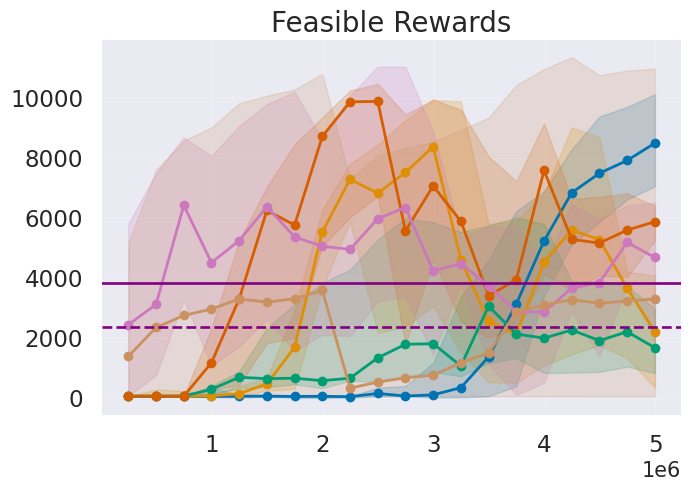

In [44]:
env="half_cheetah"
ax = plot_iqm(all_df.loc[(all_df.env==env), :], metric="feasible_reward", max_time=5000000, bootstrap_samples=n_boot, num_seeds=num_seeds)
ax.axhline(np.array(results["feasible_reward"][env]["MECL"]).mean(), c='purple', ls='--', lw=1.9, label="MECL")
ax.axhline(np.array(results["feasible_reward"][env]["GACL"]).mean(), c='purple', ls='-', lw=1.9, label="GACL")
ax.legend()
ax.set_title("Feasible Rewards", fontsize=20)
# ax.set_xticklabels(ax.get_xticklabels()*1000000, fontsize=15)
ax.set_ylabel(None)
ax.set_xlabel(None)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=[NAMES_DICT[n] for n in labels])
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_learning_curve.pdf")


5000000
1001


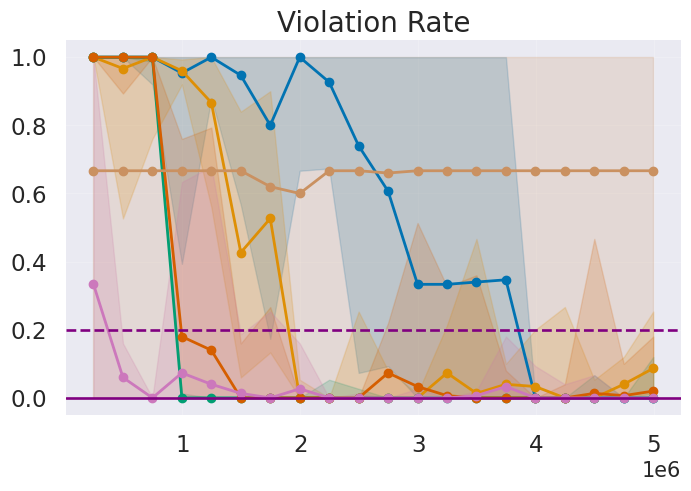

In [45]:
env = "half_cheetah"
ax = plot_iqm(all_df.loc[(all_df.env==env), :], metric="violation_rate", max_time=5000000, bootstrap_samples=n_boot, num_seeds=num_seeds)
ax.axhline(np.array(results["violation_rate"][env]["MECL"]).mean(), c='purple', ls='--', lw=1.9, label="MECL")
ax.axhline(np.array(results["violation_rate"][env]["GACL"]).mean(), c='purple', ls='-', lw=1.9, label="GACL")
ax.legend()
ax.set_title("Violation Rate", fontsize=20)

# ax.set_xticklabels(ax.get_xticklabels()*1000000, fontsize=15)
ax.set_ylabel(None)
ax.set_xlabel(None)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=[NAMES_DICT[n] for n in labels])
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_viol_lc.pdf")


#### Swimmer

5000000
1001


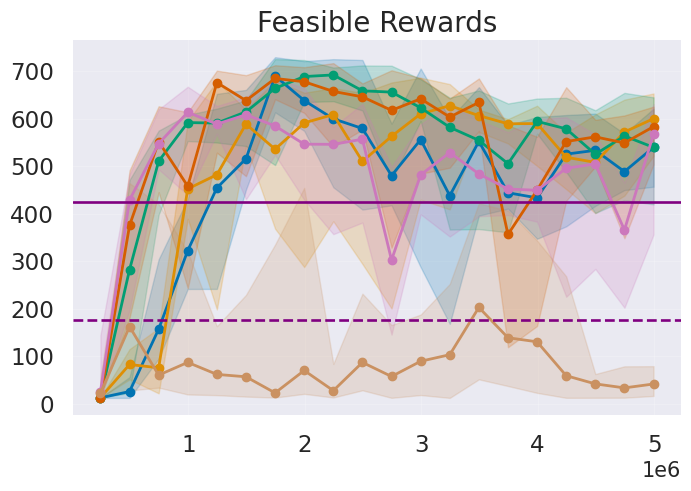

In [46]:
env="swimmer"
ax = plot_iqm(all_df.loc[(all_df.env==env), :], metric="feasible_reward", max_time=5000000, bootstrap_samples=n_boot, num_seeds=num_seeds)
ax.axhline(np.array(results["feasible_reward"][env]["MECL"]).mean(), c='purple', ls='--', lw=1.9, label="MECL")
ax.axhline(np.array(results["feasible_reward"][env]["GACL"]).mean(), c='purple', ls='-', lw=1.9, label="GACL")
ax.legend()
ax.set_title("Feasible Rewards", fontsize=20)

# ax.set_xticklabels(ax.get_xticklabels()*1000000, fontsize=15)
ax.set_ylabel(None)
ax.set_xlabel(None)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=[NAMES_DICT[n] for n in labels])
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_learning_curve.pdf")


5000000
1001


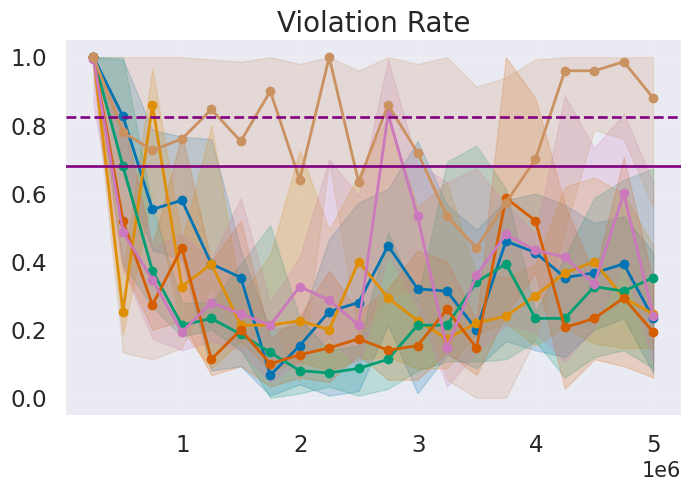

In [47]:
env = "swimmer"
ax = plot_iqm(all_df.loc[(all_df.env==env), :], metric="violation_rate", max_time=5000000, bootstrap_samples=n_boot, num_seeds=num_seeds)
ax.axhline(np.array(results["violation_rate"][env]["MECL"]).mean(), c='purple', ls='--', lw=1.9, label="MECL")
ax.axhline(np.array(results["violation_rate"][env]["GACL"]).mean(), c='purple', ls='-', lw=1.9, label="GACL")
ax.legend()
ax.set_title("Violation Rate", fontsize=20)

# ax.set_xticklabels(ax.get_xticklabels()*1000000, fontsize=15)
ax.set_ylabel(None)
ax.set_xlabel(None)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=[NAMES_DICT[n] for n in labels])
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_viol_lc.pdf")


#### Ant

5000000
1001


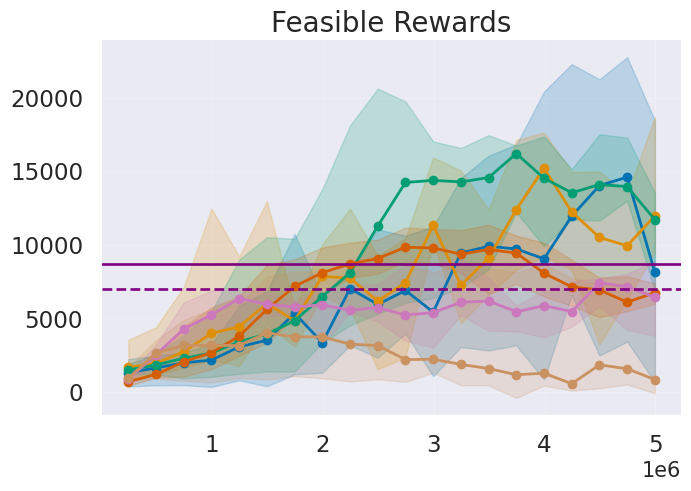

In [48]:
env="ant"
ax = plot_iqm(all_df.loc[(all_df.env==env), :], metric="feasible_reward", max_time=5000000, bootstrap_samples=n_boot, num_seeds=num_seeds)
ax.axhline(np.array(results["feasible_reward"][env]["MECL"]).mean(), c='purple', ls='--', lw=1.9, label="MECL")
ax.axhline(np.array(results["feasible_reward"][env]["GACL"]).mean(), c='purple', ls='-', lw=1.9, label="GACL")
ax.legend()
ax.set_title("Feasible Rewards", fontsize=20)

# ax.set_xticklabels(ax.get_xticklabels()*1000000, fontsize=15)
ax.set_ylabel(None)
ax.set_xlabel(None)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=[NAMES_DICT[n] for n in labels])
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_learning_curve.pdf")


5000000
1001


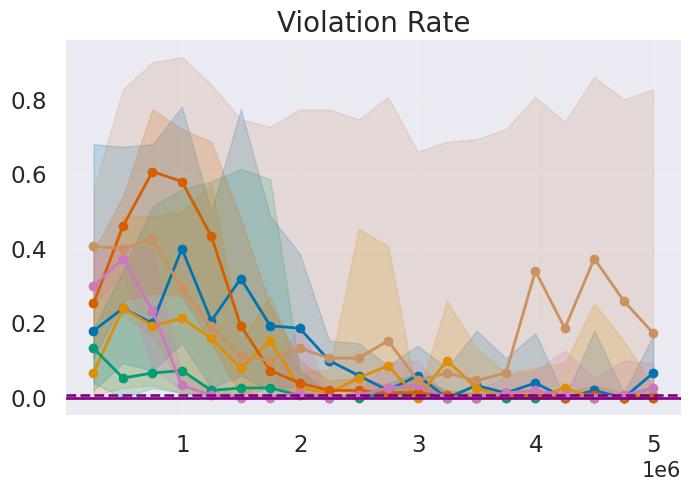

In [49]:
env = "ant"
ax = plot_iqm(all_df.loc[(all_df.env==env), :], metric="violation_rate", max_time=5000000, bootstrap_samples=n_boot, num_seeds=num_seeds)
ax.axhline(np.array(results["violation_rate"][env]["MECL"]).mean(), c='purple', ls='--', lw=1.9, label="MECL")
ax.axhline(np.array(results["violation_rate"][env]["GACL"]).mean(), c='purple', ls='-', lw=1.9, label="GACL")
ax.legend()
ax.set_title("Violation Rate", fontsize=20)

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_viol_lc.pdf")


#### Walker2D

5000000
1001


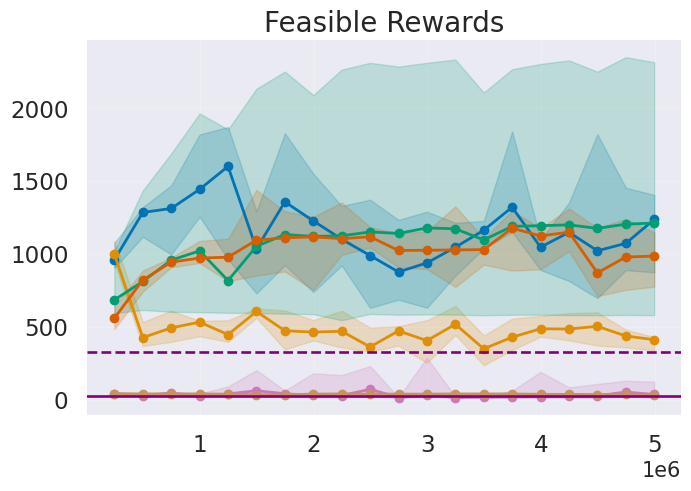

In [50]:
env="walker2d"
ax = plot_iqm(all_df.loc[(all_df.env==env), :], metric="feasible_reward", max_time=5000000, bootstrap_samples=n_boot, num_seeds=num_seeds)
ax.axhline(np.array(results["feasible_reward"][env]["MECL"]).mean(), c='purple', ls='--', lw=1.9, label="MECL")
ax.axhline(np.array(results["feasible_reward"][env]["GACL"]).mean(), c='purple', ls='-', lw=1.9, label="GACL")
ax.legend()
ax.set_title("Feasible Rewards", fontsize=20)

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_learning_curve.pdf")


5000000
1001


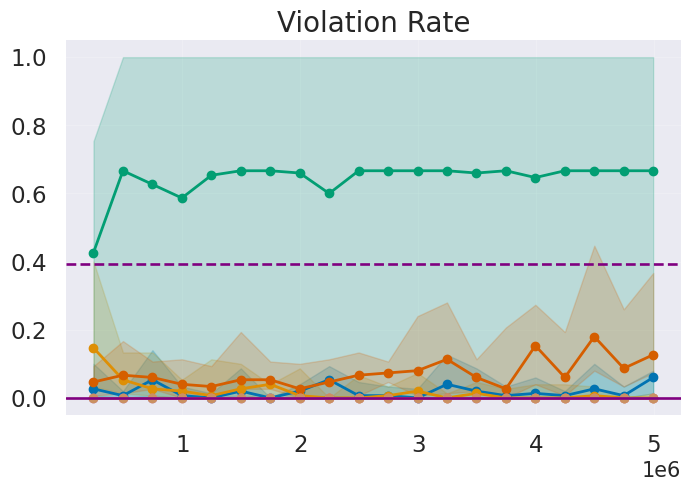

In [51]:
env = "walker2d"
ax = plot_iqm(all_df.loc[(all_df.env==env), :], metric="violation_rate", max_time=5000000, bootstrap_samples=n_boot, num_seeds=num_seeds)
ax.axhline(np.array(results["violation_rate"][env]["MECL"]).mean(), c='purple', ls='--', lw=1.9, label="MECL")
ax.axhline(np.array(results["violation_rate"][env]["GACL"]).mean(), c='purple', ls='-', lw=1.9, label="GACL")
ax.legend()
ax.set_title("Violation Rate", fontsize=20)

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_viol_lc.pdf")


#### Inverted Pendulum

5000000
1001


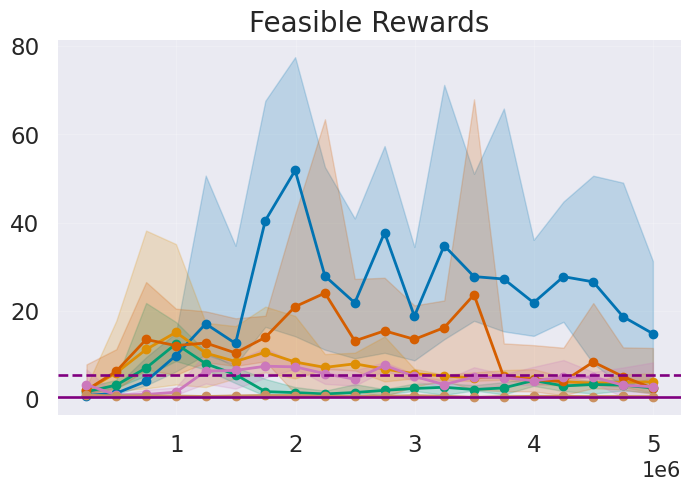

In [52]:
env="inverted_pendulum"
ax = plot_iqm(all_df.loc[(all_df.env==env), :], metric="feasible_reward", max_time=5000000, bootstrap_samples=n_boot, num_seeds=num_seeds)
ax.axhline(np.array(results["feasible_reward"][env]["MECL"]).mean(), c='purple', ls='--', lw=1.9, label="MECL")
ax.axhline(np.array(results["feasible_reward"][env]["GACL"]).mean(), c='purple', ls='-', lw=1.9, label="GACL")
ax.legend()
ax.set_title("Feasible Rewards", fontsize=20)

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_learning_curve.pdf")


5000000
1001


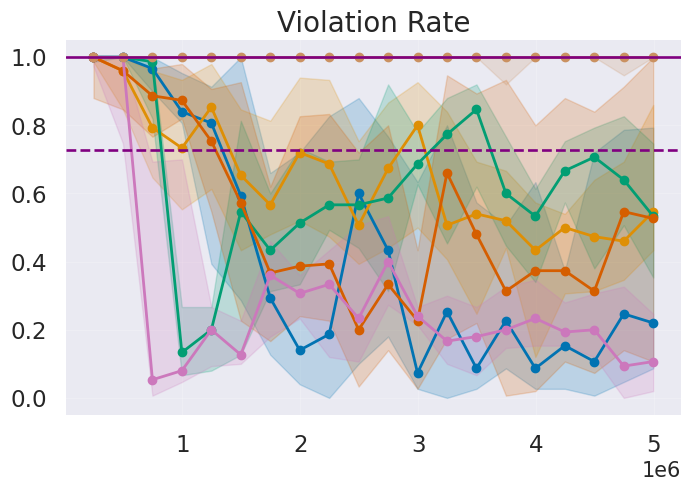

In [53]:
env = "inverted_pendulum"
ax = plot_iqm(all_df.loc[(all_df.env==env), :], metric="violation_rate", max_time=5000000, bootstrap_samples=n_boot, num_seeds=num_seeds)
ax.axhline(np.array(results["violation_rate"][env]["MECL"]).mean(), c='purple', ls='--', lw=1.9, label="MECL")
ax.axhline(np.array(results["violation_rate"][env]["GACL"]).mean(), c='purple', ls='-', lw=1.9, label="GACL")
ax.legend()
ax.set_title("Violation Rate", fontsize=20)

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_viol_lc.pdf")


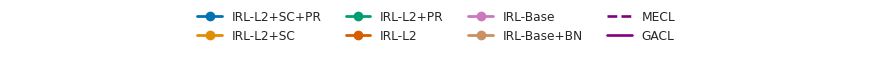

In [54]:
save_ax = ax
fig, ax = plt.subplots(1,1, figsize = (11,0.2))
plt.figlegend(*save_ax.get_legend_handles_labels(), loc = 'upper center', ncols=4, frameon=False)
fig.set_frameon(False)
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(f"plots/camera_ready/legend_lr.pdf", bbox_inches='tight')

### Overall

In [55]:
algorithms = ["GACL", "MECL", "IRL-Base", "IRL-L2", "IRL-L2+PR", "IRL-L2+SC", "IRL-L2+SC+PR"]

In [56]:
norm_rewards_by_env = results["normalized_rewards"]
norm_rewards = {key: [] for key in list(results["feasible_reward"]['half_cheetah'].keys())}
for _, val in norm_rewards_by_env.items():
    for k, v in val.items():
        norm_rewards[k].append(v)
norm_rewards = {NAMES_DICT[key]: np.array(val).T for key, val in norm_rewards.items()}

In [57]:
viol_rate_by_env = results["violation_rate"]
viol_rate = {key: [] for key in list(results["feasible_reward"]['half_cheetah'].keys())}
for _, val in viol_rate_by_env.items():
    for k, v in val.items():
        viol_rate[k].append(v)
viol_rate = {NAMES_DICT[key]: np.array(val).T for key, val in viol_rate.items()}

In [58]:
fr_scores, fr_score_cis = get_aggregate_scores(norm_rewards, mets=["iqm", "median", "mean", "optimality_gap"])
vr_scores, vr_score_cis = get_aggregate_scores(viol_rate, mets=["iqm", "median", "mean", "optimality_gap"])


In [59]:
temp = {"GACL": "GACL", "MECL": "MECL", "IRL-Base": "IRL-Base (Ours)", "IRL-L2+SC+PR": "IRL-Plus (Ours)"}

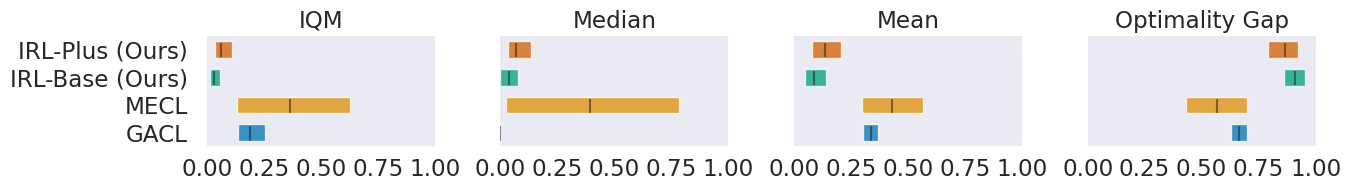

In [60]:

aggregate_scores = {temp[key]: val for key,val in vr_scores.items() if key in temp.keys()}
aggregate_score_cis = {temp[key]: val for key,val in vr_score_cis.items() if key in temp.keys()}
fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM', "Median", "Mean", "Optimality Gap"],
  algorithms=[val for key,val in temp.items()], xlabel=None)
[ax.set_xlim([0, 1]) for ax in axes]
[ax.grid(False) for ax in axes]
fig.set_figheight(2)
plt.tight_layout()
plt.savefig("plots/camera_ready/overall_viol.pdf")

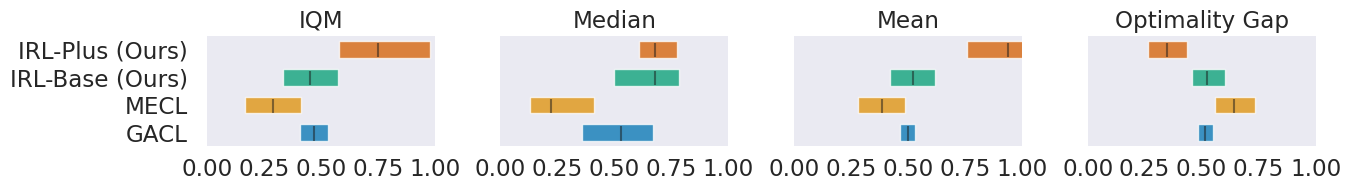

In [61]:
aggregate_scores = {temp[key]: val for key,val in fr_scores.items() if key in temp.keys()}
aggregate_score_cis = {temp[key]: val for key,val in fr_score_cis.items() if key in temp.keys()}
fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM', "Median", "Mean", "Optimality Gap"],
  algorithms=[val for key,val in temp.items()], xlabel=None)
[ax.set_xlim([0, 1]) for ax in axes]
[ax.grid(False) for ax in axes]
fig.set_figheight(2)
plt.tight_layout()
plt.savefig("plots/camera_ready/overall_reward.pdf")

In [62]:
plot_names = {"IRL-L2+SC+PR": "IRL+L2+PR+SC (IRL-Plus)", "IRL-L2+SC": "IRL+L2+SC", "IRL-L2+PR": "IRL+L2+PR", 
              "IRL-L2": "IRL+L2", "IRL-Base": "IRL (IRL-Base)", "MECL": "MECL", "GACL": "GACL"}

In [63]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        print(label)
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0, fontsize=15)


Text(0, 0, 'IRL (IRL-Base)')
Text(0, 1, 'IRL+L2')
Text(0, 2, 'IRL+L2+PR')
Text(0, 3, 'IRL+L2+SC')
Text(0, 4, 'IRL+L2+PR+SC (IRL-Plus)')


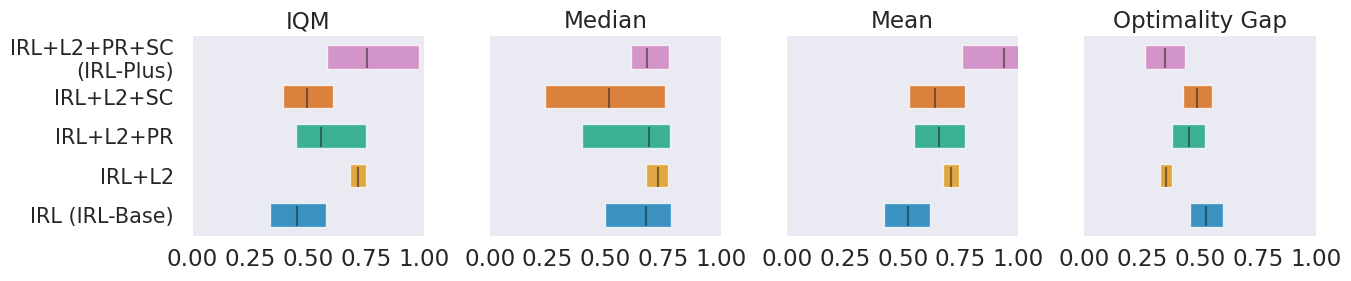

In [64]:
aggregate_scores = {plot_names[key]: val for key,val in fr_scores.items() if key not in ["MECL", "GACL", "IRL-Base+BN"]}
aggregate_score_cis = {plot_names[key]: val for key,val in fr_score_cis.items() if key not in ["MECL", "GACL", "IRL-Base+BN"]}
fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM', "Median", "Mean", "Optimality Gap"],
  algorithms=[plot_names[x] for x in algorithms if x not in ["MECL", "GACL", "IRL-Base-RN"]], xlabel=None)
[ax.set_xlim([0, 1]) for ax in axes]
[ax.grid(False) for ax in axes]

wrap_labels(axes[0], 16)
fig.set_figheight(2.9)
plt.tight_layout()
plt.savefig("plots/camera_ready/ablations_reward.pdf")

Text(0, 0, 'IRL (IRL-Base)')
Text(0, 1, 'IRL+L2')
Text(0, 2, 'IRL+L2+PR')
Text(0, 3, 'IRL+L2+SC')
Text(0, 4, 'IRL+L2+PR+SC (IRL-Plus)')


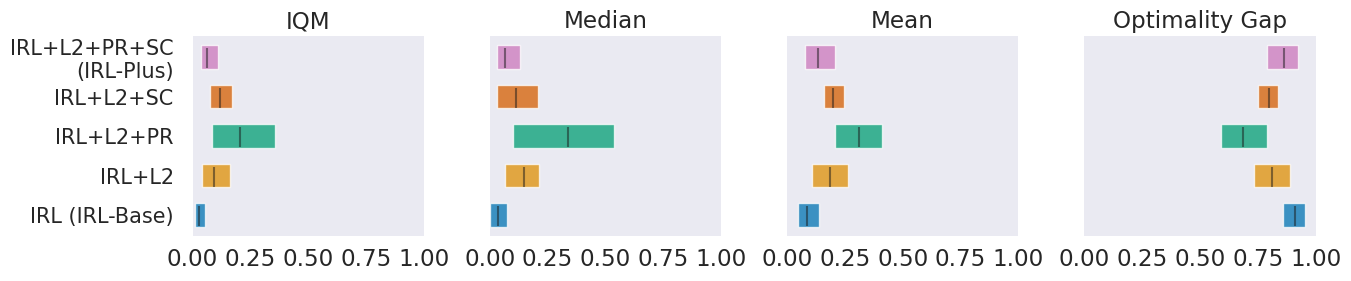

In [65]:
aggregate_scores = {plot_names[key]: val for key,val in vr_scores.items() if key not in ["MECL", "GACL", "IRL-Base+BN"]}
aggregate_score_cis = {plot_names[key]: val for key,val in vr_score_cis.items() if key not in ["MECL", "GACL", "IRL-Base+BN"]}
fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM', "Median", "Mean", "Optimality Gap"],
  algorithms=[plot_names[x] for x in algorithms if x not in ["MECL", "GACL", "IRL-Base+BN"]], xlabel=None)
[ax.set_xlim([0, 1]) for ax in axes]
[ax.grid(False) for ax in axes]

wrap_labels(axes[0], 16)
fig.set_figheight(2.9)
plt.tight_layout()
plt.savefig("plots/camera_ready/ablations_viol.pdf")

### By Environment

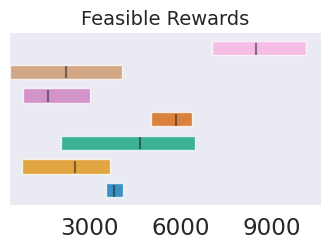

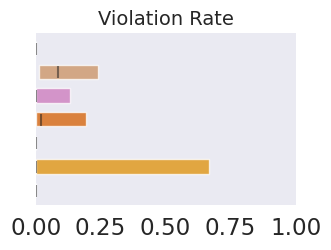

In [66]:

env = "half_cheetah"
fr = {NAMES_DICT[key]: val for key,val in results['feasible_reward'][env].items()}
aggregate_scores, aggregate_score_cis = get_aggregate_scores(fr)
fig1, axes1 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=algorithms, xlabel=None)
axes1.set_title("Feasible Rewards", fontsize=14)
axes1.get_yaxis().set_ticks([])
axes1.grid(False)
plt.tight_layout()
plt.savefig(f"plots/camera_ready/fr_iqm_{env}.pdf")
vr = {NAMES_DICT[key]: val for key,val in results['violation_rate'][env].items()}
aggregate_scores, aggregate_score_cis = get_aggregate_scores(vr)
fig2, axes2 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=algorithms, xlabel=None, xticks=None)
axes2.set_title("Violation Rate", fontsize=14)
axes2.get_yaxis().set_ticks([])
axes2.set_xlim([0, 1])
axes2.grid(False)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/viol_iqm_{env}.pdf")

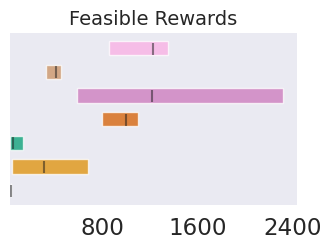

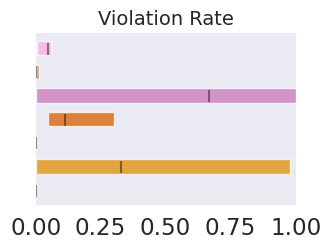

In [67]:
env = "walker2d"
fr = {NAMES_DICT[key]: val for key,val in results['feasible_reward'][env].items()}
aggregate_scores, aggregate_score_cis = get_aggregate_scores(fr)
fig1, axes1 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=algorithms, xlabel=None)
axes1.set_title("Feasible Rewards", fontsize=14)
axes1.get_yaxis().set_ticks([])
axes1.grid(False)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/fr_iqm_{env}.pdf")
vr = {NAMES_DICT[key]: val for key,val in results['violation_rate'][env].items()}
aggregate_scores, aggregate_score_cis = get_aggregate_scores(vr)
fig2, axes2 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=algorithms, xlabel=None, xticks=None)
axes2.set_title("Violation Rate", fontsize=14)
axes2.get_yaxis().set_ticks([])
axes2.set_xlim([0, 1])

axes2.grid(False)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/viol_iqm_{env}.pdf")

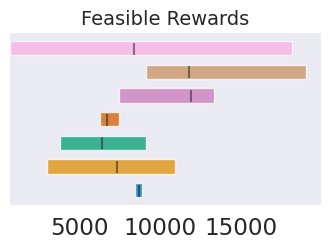

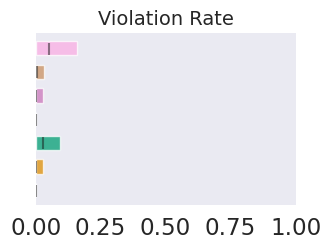

In [68]:
env = "ant"
fr = {NAMES_DICT[key]: val for key,val in results['feasible_reward'][env].items()}
aggregate_scores, aggregate_score_cis = get_aggregate_scores(fr)
fig1, axes1 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=algorithms, xlabel=None)
axes1.set_title("Feasible Rewards", fontsize=14)
axes1.get_yaxis().set_ticks([])
axes1.grid(False)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/fr_iqm_{env}.pdf")
vr = {NAMES_DICT[key]: val for key,val in results['violation_rate'][env].items()}
aggregate_scores, aggregate_score_cis = get_aggregate_scores(vr)
fig2, axes2 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=algorithms, xlabel=None, xticks=None)
axes2.set_title("Violation Rate", fontsize=14)
axes2.get_yaxis().set_ticks([])
axes2.set_xlim([0, 1])

axes2.grid(False)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/viol_iqm_{env}.pdf")

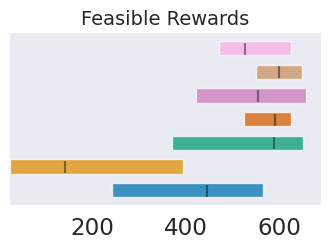

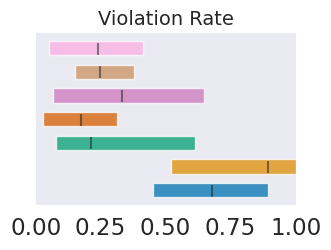

In [69]:
env = "swimmer"
fr = {NAMES_DICT[key]: val for key,val in results['feasible_reward'][env].items()}
aggregate_scores, aggregate_score_cis = get_aggregate_scores(fr)
fig1, axes1 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=algorithms, xlabel=None)
axes1.set_title("Feasible Rewards", fontsize=14)
axes1.get_yaxis().set_ticks([])
axes1.grid(False)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/fr_iqm_{env}.pdf")
vr = {NAMES_DICT[key]: val for key,val in results['violation_rate'][env].items()}
aggregate_scores, aggregate_score_cis = get_aggregate_scores(vr)
fig2, axes2 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=algorithms, xlabel=None, xticks=None)
axes2.set_title("Violation Rate", fontsize=14)
axes2.get_yaxis().set_ticks([])
axes2.set_xlim([0, 1])

axes2.grid(False)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/viol_iqm_{env}.pdf")

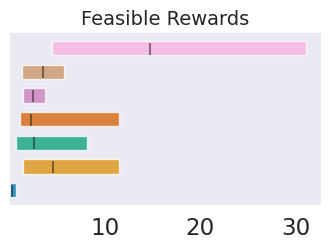

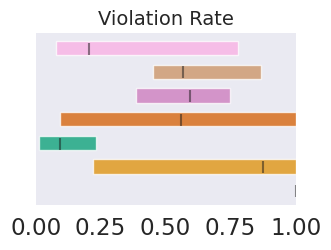

In [70]:
env = "inverted_pendulum"
fr = {NAMES_DICT[key]: val for key,val in results['feasible_reward'][env].items()}
aggregate_scores, aggregate_score_cis = get_aggregate_scores(fr)
fig1, axes1 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=algorithms, xlabel=None)
axes1.set_title("Feasible Rewards", fontsize=14)
axes1.get_yaxis().set_ticks([])
axes1.grid(False)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/fr_iqm_{env}.pdf")
vr = {NAMES_DICT[key]: val for key,val in results['violation_rate'][env].items()}
aggregate_scores, aggregate_score_cis = get_aggregate_scores(vr)
fig2, axes2 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=algorithms, xlabel=None, xticks=None)
axes2.set_title("Violation Rate", fontsize=14)
axes2.get_yaxis().set_ticks([])
axes2.set_xlim([0, 1])
axes2.tick_params(direction="in")

axes2.grid(False)
plt.tight_layout()
plt.savefig(f"plots/camera_ready/viol_iqm_{env}.pdf")

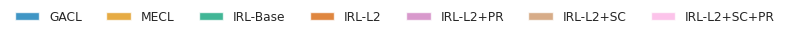

In [71]:
fig, ax = plt.subplots(1,1, figsize = (8,0.4))
legend_handles = ([x for x,y in zip(axes1.get_legend_handles_labels()[0], axes1.get_legend_handles_labels()[1]) if not isinstance(x, matplotlib.collections.LineCollection)],
 [y for x,y in zip(axes1.get_legend_handles_labels()[0], axes1.get_legend_handles_labels()[1]) if not isinstance(x, matplotlib.collections.LineCollection)]
)
plt.figlegend(*legend_handles, loc = 'upper center', ncols=8, frameon=False)
fig.set_frameon(False)
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig("plots/camera_ready/legend_iqm.pdf")

## Suboptimal Expert Trajectories

In [72]:
experiment_names = ["sc_l2_pr_warmstart_lag0_sub2", "sc_l2_pr_warmstart_lag0_sub5", "sc_l2_pr_warmstart_lag0_sub8"]
experiments = [api.runs(entity + "/" + project, filters={'tags': exp}) for exp in experiment_names]
runs = [run for runs in experiments for run in runs ]
env_name_fn = lambda x: '_'.join(re.sub(r"([A-Z])", r"_\1", x['task'].split('-')[0]).split('_')[1:-1]).lower()
subopt_df = get_data(runs, env_name_fn=env_name_fn)


In [73]:
subopt_results_df = subopt_df.sort_values(["env", "config", "run_id", "_step"]).groupby(["env", "config", "run_id"]).tail(10).groupby(["env", "config", "run_id"]).mean()
subopt_results_df = subopt_results_df.reset_index(drop=False)
subopt_results_df['env'] = subopt_results_df.config.str.split("_").str[-1]
subopt_results_df['config'] = "IRL-Plus (Ours)"

In [74]:
envname_dict = {"AntWall": "ant", "HCWithPos": "half_cheetah", "InvertedPendulumWall": "inverted_pendulum", 
                "WalkerWithPos": "walker2d", "SwmWithPos": "swimmer"}
experiment_names = ["GACL_sub2", "GACL_sub5", "GACL_sub8"]
experiments = [api.runs(entity + "/icrl", filters={'tags': exp}) for exp in experiment_names]
runs = [run for runs in experiments for run in runs ]
baseline_env_name_fn = lambda x: envname_dict[re.match(r".*_(\w+)-v0.*", runs[0].config['config_file']).group(1)]
gacl_subopt_df = get_data(runs, env_name_fn=baseline_env_name_fn,
                              metrics=["true/mean_nc_reward", "true/violation_rate"],
                              x_axis="timestep", index=None).rename(columns={"mean_nc_reward": "feasible_reward", 
                                                                          "violation_rate": "violation_rate",
                                                                          "timestep": "_step"})
experiment_names = ["MECL_sub2", "MECL_sub5", "MECL_sub8"]
experiments = [api.runs(entity + "/icrl", filters={'tags': exp}) for exp in experiment_names]
runs = [run for runs in experiments for run in runs ]
baseline_env_name_fn = lambda x: envname_dict[re.match(r".*_(\w+)-v0.*", runs[0].config['config_file']).group(1)]
mecl_subopt_df = get_data(runs, env_name_fn=baseline_env_name_fn,
                              metrics=["rollout/ep_reward_nc_mean", "rollout/ep_constraint_mean"],
                              x_axis="timesteps", index=None).rename(columns={"ep_reward_nc_mean": "feasible_reward", 
                                                                          "ep_constraint_mean": "violation_rate",
                                                                          "timesteps": "_step"})

In [75]:
subopt_mecl_results_df = mecl_subopt_df.sort_values(["env", "config", "run_id", "_step"]).groupby(["env", "config", "run_id"]).last().groupby(["env", "config", "run_id"]).mean()
subopt_mecl_results_df = subopt_mecl_results_df.reset_index(drop=False)
subopt_mecl_results_df['env'] = subopt_mecl_results_df.config.str.split("_").str[-1]
subopt_mecl_results_df['config'] = "MECL"
subopt_gacl_results_df = gacl_subopt_df.sort_values(["env", "config", "run_id", "_step"]).groupby(["env", "config", "run_id"]).last().groupby(["env", "config", "run_id"]).mean()
subopt_gacl_results_df = subopt_gacl_results_df.reset_index(drop=False)
subopt_gacl_results_df['env'] = subopt_gacl_results_df.config.str.split("_").str[-1]
subopt_gacl_results_df['config'] = "GACL"

In [76]:
subopt_results_df = pd.concat([subopt_results_df, subopt_gacl_results_df, subopt_mecl_results_df])

In [77]:
subopt_results = {}
subopt_results["feasible_reward"] = subopt_results_df.groupby(["env", "config"]).feasible_reward.apply(list)
subopt_results["violation_rate"] = subopt_results_df.groupby(["env", "config"]).violation_rate.apply(list)
subopt_results["feasible_reward"] = subopt_results["feasible_reward"].groupby(level=0).apply(lambda df: [df.xs(df.name).to_dict()]).to_dict()
subopt_results["violation_rate"] = subopt_results["violation_rate"].groupby(level=0).apply(lambda df: [df.xs(df.name).to_dict()]).to_dict()
subopt_results["feasible_reward"] = {k: v[0] for k,v in subopt_results["feasible_reward"].items()}
subopt_results["violation_rate"] = {k: v[0] for k,v in subopt_results["violation_rate"].items()}

In [78]:
for exp in ["MECL", "GACL"]:
    for env in ["sub2", "sub5", "sub8"]:
        fr = []
        vr = []
        for seed in range(5):
            temp = pd.DataFrame()
            # try:
            for monitor in range(5):
                name = 'icrl' if exp=='MECL' else 'gail'
                temp = pd.concat([temp, pd.read_csv(f"../results/{name}/half_cheetah_{env}/seed_{seed}/r{monitor}_monitor.csv", header=1).tail(10)])
            fr.append(temp.reward_nc.mean())
            vr.append(temp.constraint.mean())
            # except:
            #     continue
        if len(fr) > 0:
            subopt_results["feasible_reward"][env][exp] = fr
            subopt_results["violation_rate"][env][exp] = vr


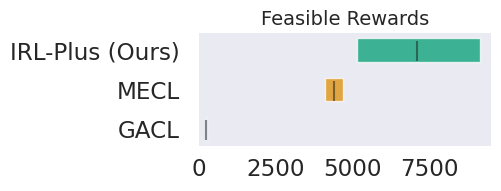

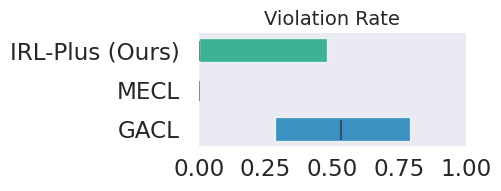

In [79]:
env = "sub2"
fr = subopt_results['feasible_reward'][env]
aggregate_scores, aggregate_score_cis = get_aggregate_scores(fr)
fig1, axes1 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=["GACL", "MECL", "IRL-Plus (Ours)"], xlabel=None)
axes1.set_title("Feasible Rewards", fontsize=14)
axes1.set_xlim([0,9500])
axes1.grid(False)

# axes1.get_yaxis().set_ticks([])
fig1.set_figheight(2)
fig1.set_figwidth(5.1)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/fr_iqm_{env}.pdf")
vr = subopt_results['violation_rate'][env]
aggregate_scores, aggregate_score_cis = get_aggregate_scores(vr)
fig2, axes2 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=["GACL", "MECL", "IRL-Plus (Ours)"], xlabel=None, xticks=None)
axes2.set_title("Violation Rate", fontsize=14)
axes2.set_xlim([0,1])
axes2.grid(False)

# axes2.get_yaxis().set_ticks([])
fig2.set_figheight(2)
fig2.set_figwidth(5.1)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/viol_iqm_{env}.pdf")

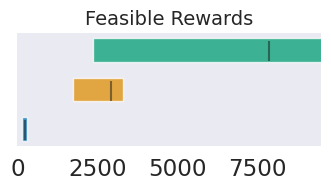

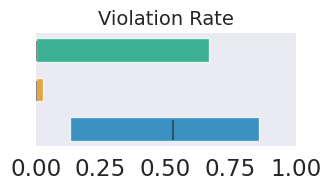

In [80]:
env = "sub5"
fr = subopt_results['feasible_reward'][env]
aggregate_scores, aggregate_score_cis = get_aggregate_scores(fr)
fig1, axes1 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=["GACL", "MECL", "IRL-Plus (Ours)"], xlabel=None)
axes1.set_title("Feasible Rewards", fontsize=14)
axes1.get_yaxis().set_ticks([])
axes1.set_xlim([0,9500])
axes1.grid(False)
fig1.set_figheight(2)
plt.tight_layout()
plt.savefig(f"plots/camera_ready/fr_iqm_{env}.pdf")
vr = subopt_results['violation_rate'][env]
aggregate_scores, aggregate_score_cis = get_aggregate_scores(vr)
fig2, axes2 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=["GACL", "MECL", "IRL-Plus (Ours)"], xlabel=None, xticks=None)
axes2.set_title("Violation Rate", fontsize=14)
axes2.get_yaxis().set_ticks([])
axes2.set_xlim([0,1])
axes2.grid(False)
fig2.set_figheight(2)
plt.tight_layout()
plt.savefig(f"plots/camera_ready/viol_iqm_{env}.pdf")

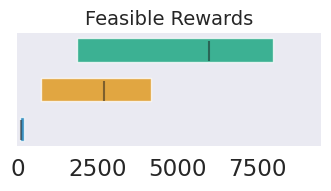

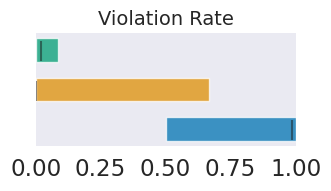

In [81]:
env = "sub8"
fr = subopt_results['feasible_reward'][env]
aggregate_scores, aggregate_score_cis = get_aggregate_scores(fr)
fig1, axes1 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=["GACL", "MECL", "IRL-Plus (Ours)"], xlabel=None)
axes1.set_title("Feasible Rewards", fontsize=14)
axes1.get_yaxis().set_ticks([])
axes1.set_xlim([0,9500])
axes1.grid(False)
fig1.set_figheight(2)
plt.tight_layout()
plt.savefig(f"plots/camera_ready/fr_iqm_{env}.pdf")
vr = subopt_results['violation_rate'][env]
aggregate_scores, aggregate_score_cis = get_aggregate_scores(vr)
fig2, axes2 = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM'],
  algorithms=["GACL", "MECL", "IRL-Plus (Ours)"], xlabel=None, xticks=None)
axes2.set_title("Violation Rate", fontsize=14)
axes2.get_yaxis().set_ticks([])
axes2.set_xlim([0,1])
axes2.grid(False)
fig2.set_figheight(2)
plt.tight_layout()
plt.savefig(f"plots/camera_ready/viol_iqm_{env}.pdf")

## Appendix

In [82]:
experiment_names = ["final_baseline", "best_baseline"]
experiments = [api.runs(entity + "/" + project, filters={'tags': exp}) for exp in experiment_names]
runs = [run for runs in experiments for run in runs ]
runs = [(run, '_'.join(re.sub(r"([A-Z])", r"_\1", run.config["task"].split('-')[0]).split('_')[1:-1]).lower()) for run in runs]
runs_by_env = {env: [run[0] for run in runs if run[1]==env] for env in ENVS}

In [83]:
icrl_walker_df = get_data(runs_by_env["walker2d"], env_name_fn=env_name_fn, add_from_config=["seed", "reward.optim.lr", "policy.lagrangian_optim.lr"])
icrl_walker_df['env'] = 'walker2d'
icrl_swimmer_df = get_data(runs_by_env['swimmer'], env_name_fn=env_name_fn, add_from_config=["seed", "reward.optim.lr", "policy.lagrangian_optim.lr"])
icrl_swimmer_df['env'] = 'swimmer'
icrl_cheetah_df = get_data(runs_by_env['half_cheetah'], env_name_fn=env_name_fn, add_from_config=["seed", "reward.optim.lr", "policy.lagrangian_optim.lr"])
icrl_cheetah_df['env'] = 'half_cheetah'
icrl_pendulum_df = get_data(runs_by_env['inverted_pendulum'], env_name_fn=env_name_fn, add_from_config=["seed", "reward.optim.lr", "policy.lagrangian_optim.lr"])
icrl_pendulum_df['env'] = 'inverted_pendulum'
icrl_ant_df = get_data(runs_by_env['ant'], env_name_fn=env_name_fn, add_from_config=["seed", "reward.optim.lr", "policy.lagrangian_optim.lr"])
icrl_ant_df['env'] = 'ant'
icrl_df = pd.concat([icrl_walker_df, icrl_swimmer_df, icrl_cheetah_df, icrl_pendulum_df, icrl_ant_df])

In [84]:
icrl_df['config'] = "reward.lr=" + icrl_df['reward.optim.lr'].astype(str) + ", lambda.lr=" + icrl_df['policy.lagrangian_optim.lr'].astype(str)

In [85]:
for it in icrl_df.config.unique():
    NAMES_DICT[it] = it

In [86]:
n_boot = 50000
sns.set(font_scale=1.2)

### Half Cheetah

3000000
1001


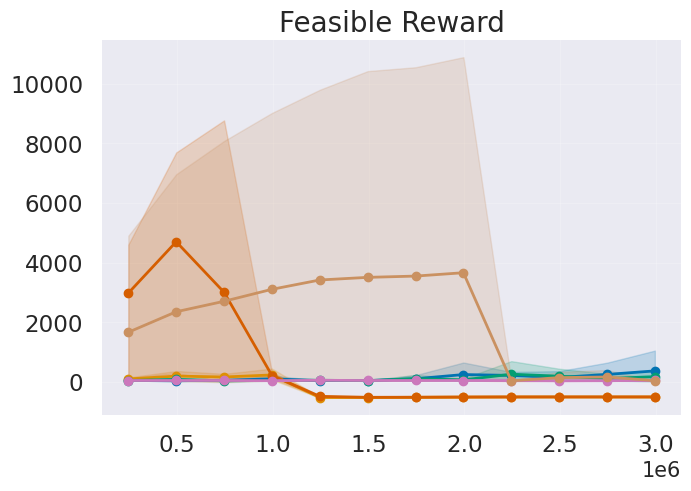

In [87]:
env="half_cheetah"
ax = plot_iqm(icrl_df[icrl_df.env==env], metric="feasible_reward", max_time=3000000, bootstrap_samples=n_boot, num_seeds=3)
ax.set_title("Feasible Reward")
ax.title.set_fontsize(20)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_icrl_sac.pdf")

3000000
1001


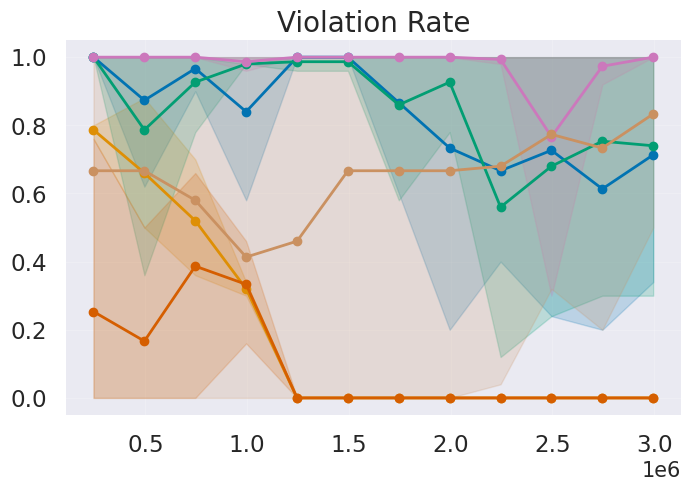

In [88]:
env="half_cheetah"
ax = plot_iqm(icrl_df[icrl_df.env==env], metric="violation_rate", max_time=3000000, bootstrap_samples=n_boot, num_seeds=3)
ax.set_title("Violation Rate")
ax.title.set_fontsize(20)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_icrl_sac_viol.pdf")

### Swimmer

3000000
1001


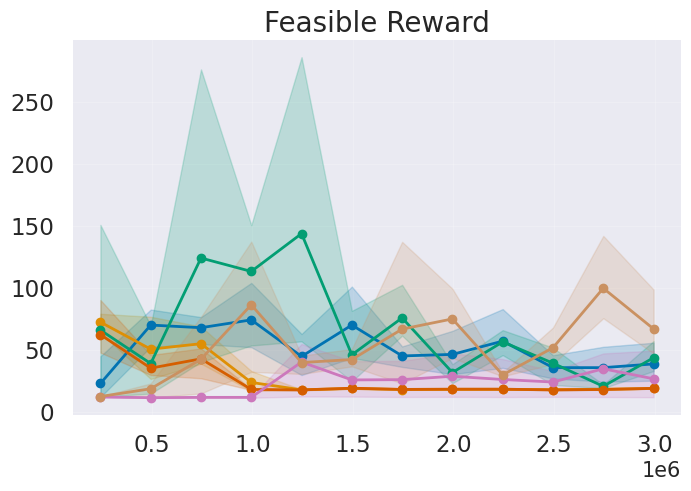

In [89]:
env="swimmer"
ax = plot_iqm(icrl_df[icrl_df.env==env], metric="feasible_reward", max_time=3000000, bootstrap_samples=n_boot, num_seeds=3)
ax.set_title("Feasible Reward")
ax.title.set_fontsize(20)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_icrl_sac.pdf")

3000000
1001


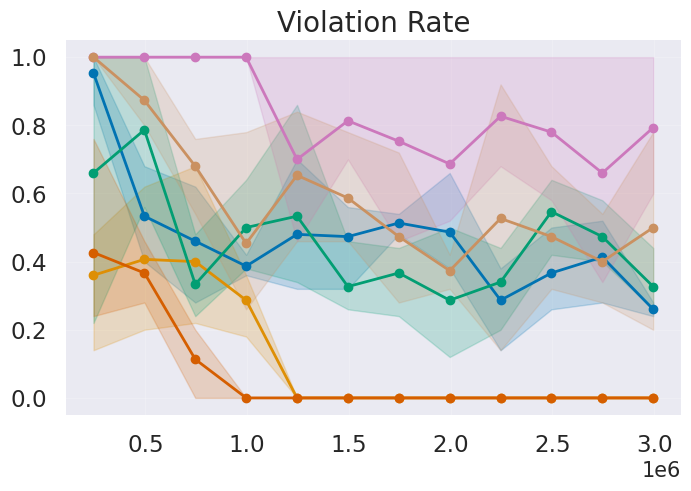

In [90]:
env="swimmer"
ax = plot_iqm(icrl_df[icrl_df.env==env], metric="violation_rate", max_time=3000000, bootstrap_samples=n_boot, num_seeds=3)
ax.set_title("Violation Rate")
ax.title.set_fontsize(20)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_icrl_sac_viol.pdf")

### Ant

3000000
1001


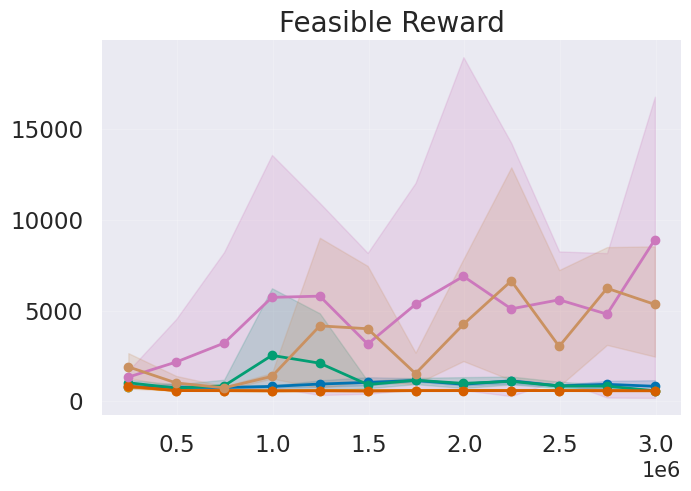

In [91]:
env="ant"
ax = plot_iqm(icrl_df[icrl_df.env==env], metric="feasible_reward", max_time=3000000, bootstrap_samples=n_boot, num_seeds=3)
ax.set_title("Feasible Reward")
ax.title.set_fontsize(20)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_icrl_sac.pdf")

3000000
1001


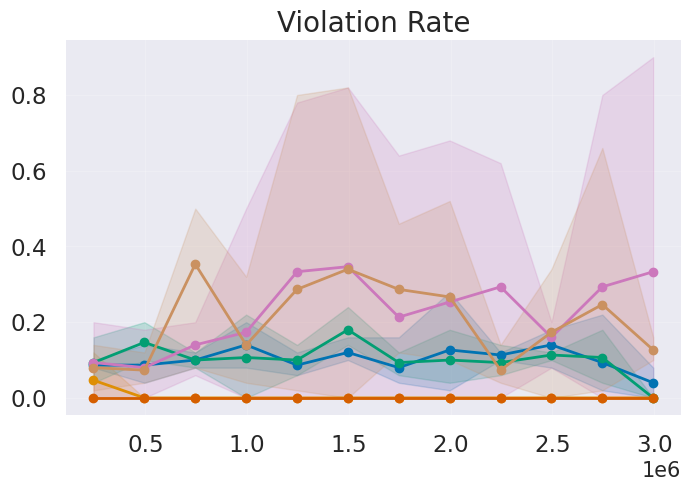

In [92]:
env="ant"
ax = plot_iqm(icrl_df[icrl_df.env==env], metric="violation_rate", max_time=3000000, bootstrap_samples=n_boot, num_seeds=3)
ax.set_title("Violation Rate")
ax.title.set_fontsize(20)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_icrl_sac_viol.pdf")

### Walker2D

3000000
1001


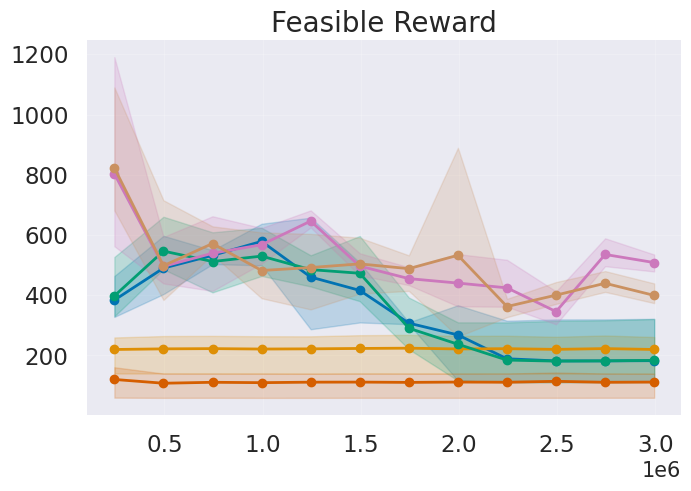

In [93]:
env="walker2d"
ax = plot_iqm(icrl_df[icrl_df.env==env], metric="feasible_reward", max_time=3000000, bootstrap_samples=n_boot, num_seeds=3)
ax.set_title("Feasible Reward")
ax.title.set_fontsize(20)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_icrl_sac.pdf")

3000000
1001


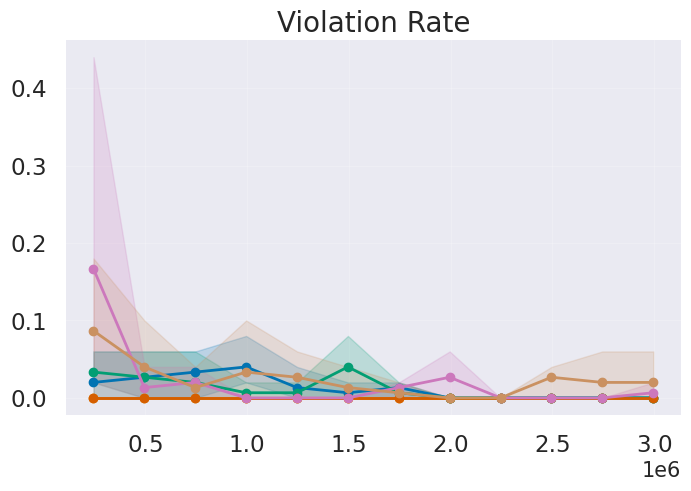

In [94]:
env="walker2d"
ax = plot_iqm(icrl_df[icrl_df.env==env], metric="violation_rate", max_time=3000000, bootstrap_samples=n_boot, num_seeds=3)
ax.set_title("Violation Rate")
ax.title.set_fontsize(20)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_icrl_sac_viol.pdf")

### Inverted Pendulum

3000000
1001


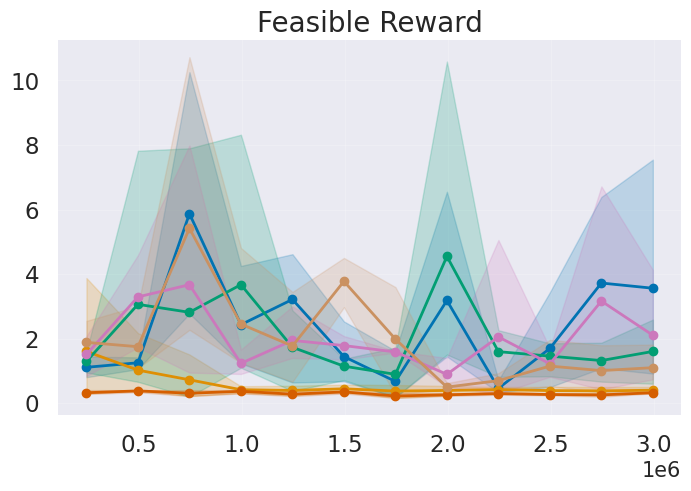

In [95]:
env="inverted_pendulum"
ax = plot_iqm(icrl_df[icrl_df.env==env], metric="feasible_reward", max_time=3000000, bootstrap_samples=n_boot, num_seeds=3)
ax.set_title("Feasible Reward")
ax.title.set_fontsize(20)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_icrl_sac.pdf")

3000000
1001


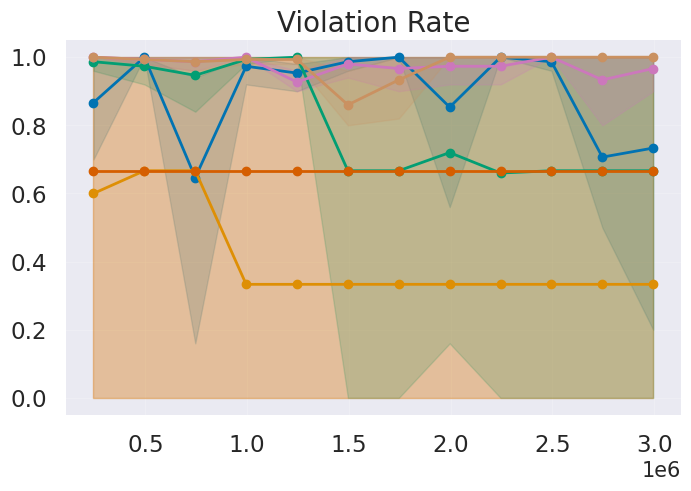

In [96]:
env="inverted_pendulum"
ax = plot_iqm(icrl_df[icrl_df.env==env], metric="violation_rate", max_time=3000000, bootstrap_samples=n_boot, num_seeds=3)
ax.set_title("Violation Rate")
ax.title.set_fontsize(20)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.get_legend().remove()
ax.xaxis.get_offset_text().set_fontsize(15)

plt.tight_layout()
plt.savefig(f"plots/camera_ready/{env}_icrl_sac_viol.pdf")

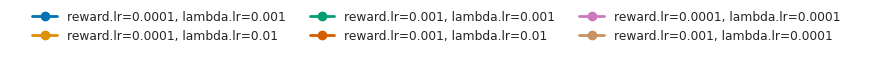

In [97]:
save_ax = ax
fig, ax = plt.subplots(1,1, figsize = (11,0.2))
plt.figlegend(*save_ax.get_legend_handles_labels(), loc = 'upper center', ncols=3, frameon=False)
fig.set_frameon(False)
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(f"plots/camera_ready/legend_icrl.pdf", bbox_inches='tight')